## 빅데이터 활용 AI 설계
# VGG-16 모델 적용

### VGG-16 이란?
- 중간층을 16~19 개로 대폭 늘려서 엄청난 성능 개선을 이룬 모델
- "Very Deep Convolutional Networks for Large-Scale Image Recognition", 2014, K. Simonyan, A. Zisserman
- ImageNet ILSVRc-2012 데이터셋 사용 (ImageNet 대회용)
- VGG-16 의 모델과 미리 학습된 가중치는 공개되어 있다.

- 1000개의 클래스, 1400만개의 데이터 세트인 ImageNet 에서 학습함
- 기타 모델 : ResNet, Inception, Inception-ResNet, Xception

### 사전 훈련된 모델 활용 방법

<img src='vgg16.jpg' />

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Keras 에 내장된 VGG-16 모델 적용

In [2]:
from keras.applications import VGG16

C:\Anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

- 위에서 이미지 크기를 "input_shape=(150,150,3)" 과 같이 지정할 수 있다.
- "input_shape" 를 지정하지 않으면 모델에서 이미지 크기를 자동으로 판단한다
- "include_top" 옵션은 콘볼루션 블록이 끝난 다음의 완전연결층 까지 불러올 것인지를 지정한다. (False 이면 콘볼루션 블록 까지만 불러온다)

In [4]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [5]:
vgg16_top = VGG16(weights='imagenet', include_top=True) # input_shape=(224,224,3) is default
vgg16_top.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### VGG-16 용으로 이미지 변환

In [8]:
from keras.preprocessing.image import load_img, img_to_array

In [9]:
image = load_img('bob_dylan.jpg') # target_size=(224, 224)

In [47]:
bob = img_to_array(image)

In [48]:
bob.shape, bob.max(), bob.dtype

((355, 355, 3), 255.0, dtype('float32'))

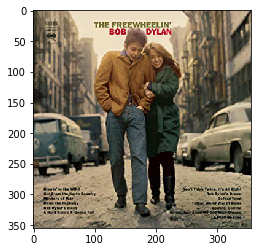

In [49]:
plt.imshow(bob/255.)

In [11]:
from keras.applications.vgg16 import preprocess_input

In [50]:
input_image = np.expand_dims(bob, axis=0)
input_image = preprocess_input(input_image)

In [51]:
input_image.shape, input_image.max(), input_image.min()

((1, 355, 355, 3), 138.22101, -123.68)

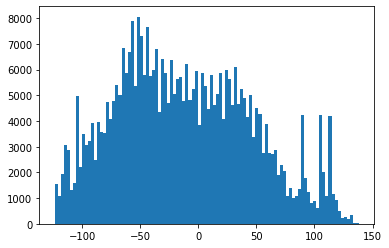

In [52]:
plt.hist(input_image.ravel(), bins=100)
pass

### 이미지 적용

In [53]:
conv_result = vgg16.predict(input_image)
conv_result.shape

(1, 11, 11, 512)

In [54]:
conv_result.max(), conv_result.min()

(153.0646, 0.0)

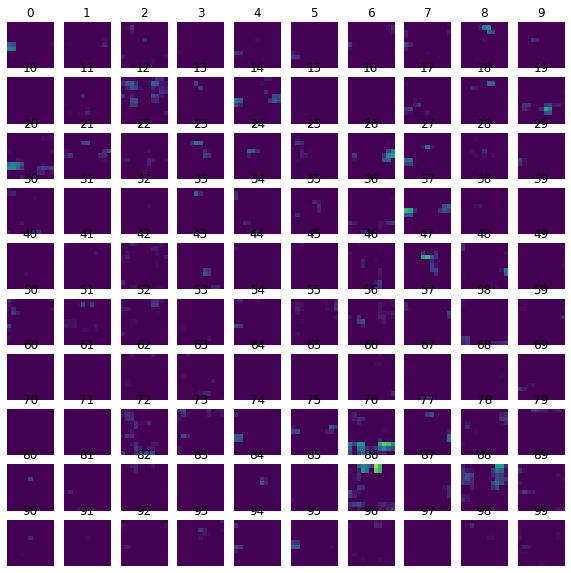

In [55]:
plt.figure(figsize=[10,10])

for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(conv_result[0,:,:,i], vmin=conv_result.min(), vmax=conv_result.max())
    plt.axis('off')
    plt.title(i)

- 위 이미지는 512개 채널 중에 100개 만 출력한 것이다.
- 대부분 0에 가깝고, 다만 76, 86번 채널에서 큰 값들이 보인다.

In [56]:
ws = vgg16.get_weights()
len(ws)

26

In [57]:
ws[-2].shape

(3, 3, 512, 512)

In [59]:
the_filter = ws[-2][:,:,:,86]
the_filter.shape

(3, 3, 512)

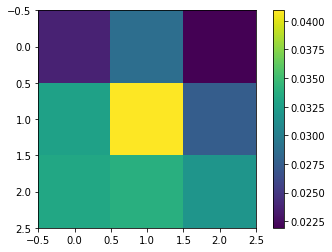

In [61]:
plt.imshow(the_filter.max(axis=2))
plt.colorbar()

### 중간 이미지 확인

In [62]:
from keras import models

#block3_conv1 = vgg16.get_layer('block3_conv1')
activation_model = models.Model(inputs=vgg16.input, outputs=vgg16.layers[7].output) # block3_conv1

In [63]:
activations = activation_model.predict(input_image)

In [66]:
activations.shape, activations.max(), activations.min()

((1, 88, 88, 256), 13410.464, 0.0)

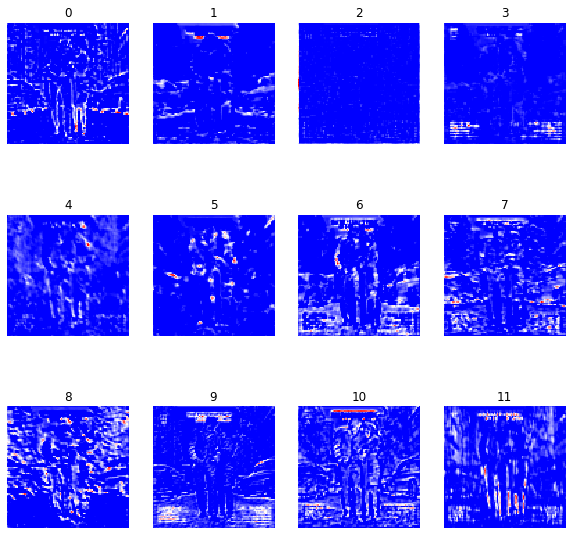

In [65]:
plt.figure(figsize=[10,10])

for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(activations[0,:,:,i], cmap='bwr')
    plt.axis('off')
    plt.title(i)

### 전체 모델을 불러와 이미지 판별하기

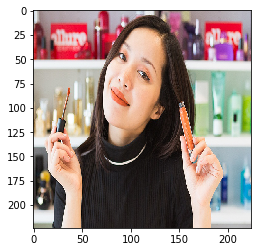

In [12]:
image = load_img('cosmetic.jpg', target_size=(224, 224))
image = img_to_array(image)
plt.imshow(image/255.)

input_image = np.expand_dims(image, axis=0)
input_image = preprocess_input(input_image)

In [13]:
result = vgg16_top.predict(input_image)

In [14]:
from keras.applications.vgg16 import decode_predictions

# decode the results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(result, top=10)[0])

Predicted: [('n04376876', 'syringe', 0.4319761), ('n07615774', 'ice_lolly', 0.19497782), ('n03676483', 'lipstick', 0.14540654), ('n03876231', 'paintbrush', 0.062094163), ('n04270147', 'spatula', 0.05345674), ('n04154565', 'screwdriver', 0.018392112), ('n03250847', 'drumstick', 0.016679648), ('n04116512', 'rubber_eraser', 0.009455682), ('n03372029', 'flute', 0.008653866), ('n03481172', 'hammer', 0.006526782)]


### VGG-16 활용
- VGG-16 의 콘볼루션 블록까지 사용하고, 그 위에 나에게 맞는 완전연결층을 올릴 수 있다.
- 개인이나 연구실의 컴퓨터로 VGG-16 과 비슷한 성능조차 내기 힘들기 때문이다.
- VGG-16 뿐만 아니라 다른 유명한 모델들도 학습된 가중치를 제공하고 있다. (인셉션-v3 등)
> - VGG-16의 가중치 : https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5